In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel

random_state = 1015

---
# Held Out, 10 Fold

## Run the held out funtion as below:

In [2]:
import importlib.util
import os

def import_module_with_full_path(file_path):
    base_filename = os.path.basename(file_path)
    module_name = os.path.splitext(base_filename)[0]
    module_spec = importlib.util.spec_from_file_location(module_name, file_path)
    imported_module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(imported_module)
    return imported_module

from joblib import dump
root = "/projects/unutmaz-lab/ruoyun/MECFS/all_tps"
heldout_10_fold = import_module_with_full_path("%s/codes/AI/module/heldout_10_fold.py"%(root))
heldout_10_fold = heldout_10_fold.heldout_and_10_fold

model_name = "immune"

input_dir = "%s/codes/AI/output/heldout_review/input"%(root)
result_dir = "%s/codes/AI/output/heldout_review/result"%(root)

data_file_path = "%s/%s.csv" %(input_dir, model_name)
metadata_file_path = "%s/metadata.csv" %(input_dir)
scores_data_file_path = "%s/score.csv" %(input_dir)

result_path = "%s/%s_result.joblib" %(result_dir, model_name)

heldout_percentage = 0.15

#heldout_10_fold(data_file_path, metadata_file_path, scores_data_file_path, result_path, heldout_percentage)

# Now read the results and Plot

# Write down the results metrics

In [3]:
def p_value_to_stars(p_value):
    """
    Convert a p-value into stars based on significance levels.
    
    Args:
        p_value (float or None): The p-value to convert.

    Returns:
        str: A string representing the significance level as stars, or '' if p_value is None.
    """
    if p_value < 0.001:
        return '***'  # Highly significant
    elif p_value < 0.01:
        return '**'   # Moderately significant
    elif p_value < 0.05:
        return '*'    # Weakly significant
    else:
        return ''
    
def format_cell(mean, std, p_value):
    significance = p_value_to_stars(p_value)
    return f"{mean:.3f} (±{std:.3f}){significance}"

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def calculate_metrics(y_true, y_prob):
    y_pred = [1 if prob >= 0.5 else 0 for prob in y_prob]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    aucpr = average_precision_score(y_true, y_prob)
    return accuracy, precision, recall, f1, auc, aucpr

In [5]:
def write_cv_metrics(model_name):
    input_dir = "/projects/unutmaz-lab/ruoyun/MECFS/all_tps/codes/AI/output/heldout_review/heldout_review"
    result_path = "%s/%s_result.joblib" %(input_dir, model_name)
    result = load(result_path)
    
    X = pd.read_csv("%s/%s_train.csv" %(input_dir, model_name), index_col=0).transpose()
    y_prob_table = pd.read_csv("%s/%s_y_prob.csv" %(input_dir, model_name),index_col=0)
    
    y0 = pd.to_numeric(y_prob_table.loc[X.index, 'y_true'], errors='coerce')
    
    kfold = StratifiedKFold(n_splits=10, random_state = result['random_state'], shuffle=True)
    
    metrics_table = pd.DataFrame(index=range(10), columns=['accuracy', 'precision', 
                                                           'recall', 'f1-score','auc','aucpr'])
    metrics_dict = {key: metrics_table.copy() for key in ['biomapai', 'dnn', 'gdbt', 'glmnet', 'glmnet-int','svm']}

    # Calculate the matrix
    fold = 0
    for train_index, test_index in kfold.split(X, y0):
        y_pred_i = y_prob_table.iloc[test_index,:]
        y_true_i = y_pred_i['y_true'].to_list()
        for i in list(metrics_dict.keys()):
            y_prob_i = y_pred_i.loc[:,"%s_y_pred"%(i)].tolist()
            metrics_dict[i].loc[fold,:] = calculate_metrics(y_true_i, y_prob_i)
        fold+=1
    
    # Now get the stats table
    mean_table = pd.DataFrame(None, index = metrics_dict.keys(), columns=metrics_table.columns)
    std_table = pd.DataFrame(None, index = metrics_dict.keys(), columns=metrics_table.columns)
    p_value_table = pd.DataFrame(None, index = metrics_dict.keys(), columns=metrics_table.columns)
    for i in list(metrics_dict.keys()):
        mean_table.loc[i,:] = metrics_dict[i].mean()
        std_table.loc[i,:] = metrics_dict[i].std()
        for j in p_value_table.columns:
            if j != 'biomapai':
                biomapai_perf_j = metrics_dict['biomapai'][j]
                model_perf_j = metrics_dict[i][j]
                _, p_value = ttest_rel(biomapai_perf_j, model_perf_j)
                p_value_table.loc[i, j] = p_value
    
    # Now format for final table
    final_table = pd.DataFrame(None, index = metrics_dict.keys(), columns=metrics_table.columns)
    for i in final_table.index:
        for j in final_table.columns:
            final_table.loc[i,j] = format_cell(mean_table.loc[i,j], std_table.loc[i,j], p_value_table.loc[i,j])
            
    return result, final_table

In [6]:
def write_holdout_metrics(model_name):
    input_dir = "/projects/unutmaz-lab/ruoyun/MECFS/all_tps/codes/AI/output/heldout_review/heldout_review"
    
    y_prob_held_out_table= pd.read_csv("%s/%s_y_prob_held_out.csv"%(input_dir, model_name),index_col=0)
    y_true = y_prob_held_out_table['y_true'].to_list()
    
    metrics_table = pd.DataFrame(index=['biomapai', 'dnn', 'gdbt', 'glmnet', 'glmnet-int','svm'], 
                                 columns=['accuracy', 'precision', 'recall', 'f1-score','auc','aucpr'])

    for i in metrics_table.index:
        y_prob_i = y_prob_held_out_table.loc[:,"%s_y_pred"%(i)].tolist()
        metrics_table.loc[i,:] = calculate_metrics(y_true, y_prob_i)
        
    return metrics_table

In [7]:
metrics_list = [write_cv_metrics(i)[1] for i in ['omics','immune','kegg','specie','metabolome','quest']]
#pd.concat(metrics_list).to_csv("/projects/unutmaz-lab/ruoyun/MECFS/all_tps/output/AI_figure/Omics_model_10cv_metrics.csv")

In [8]:
metrics_list = [write_holdout_metrics(i) for i in ['omics','immune','kegg','specie','metabolome','quest']]
#pd.concat(metrics_list).to_csv("/projects/unutmaz-lab/ruoyun/MECFS/all_tps/output/AI_figure/Omics_model_heldout_metrics.csv")

## Define color for omis

In [9]:
omics_name_list = ['immune','specie', 'kegg', 'metabolome', 'quest','omics']
colors = sns.color_palette("Set2", 6)
color_dict = dict(zip(omics_name_list, colors))

# ROC

In [10]:
import sklearn.metrics as sk_metrics
import seaborn as sns

In [11]:
def load_roc(omics_name, model_name):
    result_dir = "/projects/unutmaz-lab/ruoyun/MECFS/all_tps/codes/AI/output/heldout_review/heldout_review"
    y_prob_table = pd.read_csv("%s/%s_y_prob.csv" %(result_dir, omics_name),index_col=0)
    y_true = y_prob_table.loc[:,'y_true'].tolist()
    y_prob = y_prob_table.loc[:,"%s_y_pred"%(model_name.lower())].tolist()
    return y_true, y_prob

In [12]:
def load_roc_heldout(omics_name, model_name):
    result_dir = "/projects/unutmaz-lab/ruoyun/MECFS/all_tps/codes/AI/output/heldout_review/heldout_review"
    y_prob_table = pd.read_csv("%s/%s_y_prob_held_out.csv" %(result_dir, omics_name),index_col=0)
    y_true = y_prob_table.loc[:,'y_true'].tolist()
    y_prob = y_prob_table.loc[:,"%s_y_pred"%(model_name.lower())].tolist()
    return y_true, y_prob

In [13]:
def roc_curve_plot(y_true_list, y_prob_list, title):
    model_name_list = ['immune','specie', 'kegg', 'metabolome', 'quest','omics']
    colors = sns.color_palette("Set2", 6)
    color_dict = dict(zip(model_name_list, colors))

    assert(y_true_list.keys() == y_prob_list.keys())
    name_list = list(y_true_list.keys())
    sns.set(style='ticks', font_scale=0.95, font='sans-serif')
    fig = plt.figure(figsize=(4.5,4), constrained_layout=True)
    
    for i in name_list:
        y_true_i, y_prob_i = y_true_list[i], y_prob_list[i]
        fpr, tpr, _ = sk_metrics.roc_curve(y_true_i, y_prob_i)
        _,_,_,_,roc_auc,_ = calculate_metrics(y_true_i, y_prob_i)
        plt.plot(fpr, tpr, color=color_dict[i], lw=4, label="%s(%.2f)" %(i, roc_auc))
    plt.plot([0.01,1], [0.01,1], "--", lw=2, color='grey')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05,1.1])
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    plt.legend(loc="lower right")
    plt.title(title,fontsize=15)
    
    return plt

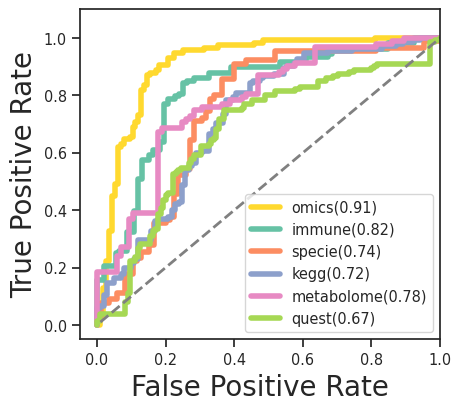

In [14]:
omics_name_list = ['omics','immune','specie', 'kegg', 'metabolome', 'quest']
y_true_list = {item: load_roc(item, "biomapai")[0] for item in omics_name_list}
y_prob_list = {item: load_roc(item, "biomapai")[1] for item in omics_name_list}
plt = roc_curve_plot(y_true_list, y_prob_list, "")
plt.savefig("/projects/unutmaz-lab/ruoyun/MECFS/all_tps/output/AI_figure/Omics_ROC.png", dpi=1000, bbox_inches='tight')

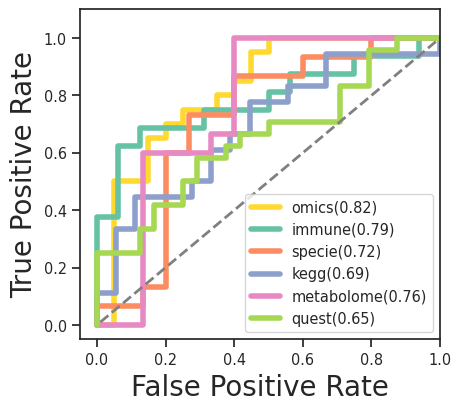

In [15]:
omics_name_list = ['omics','immune','specie', 'kegg', 'metabolome', 'quest']
y_true_list = {item: load_roc_heldout(item, "biomapai")[0] for item in omics_name_list}
y_prob_list = {item: load_roc_heldout(item, "biomapai")[1] for item in omics_name_list}
plt = roc_curve_plot(y_true_list, y_prob_list, "")
plt.savefig("/projects/unutmaz-lab/ruoyun/MECFS/all_tps/output/AI_figure/Omics_ROC_Holdout.png", dpi=1000, bbox_inches='tight')